# Sugestão de metodologia para cálculo de Intervalos de Confiança 

Conforme mencionado na LDO de 2018, o modelo oficial do governo se define como determinístico: 

“[...] *ou seja, a partir da fixação de um conjunto de variáveis, o modelo determina de maneira única seus resultados* [...]

Como se trabalha com probabilidades, não necessariamente todos os eventos previstos podem acontecer. O modelo da LDO é determinístico por trabalhar apenas com médias (ex: média de pessoas que se aposentarão) e não considera diferentes cenários onde isso pode não ocorrer, ou seja, situações diferentes do comportamento médio.

Este documento busca apresentar uma forma diferente de se projetar estoques considerando diferentes cenários onde nem sempre os segurados irão se aposentar.

In [210]:
import sys
sys.path.insert(0, '../')

from util.tabelas import LerTabelas
import modelos.fazenda as fz
%matplotlib inline


###################### Parâmetros de simulação ###############################

# Período de projeção 
periodo = list(range(2015, 2061))

# Ano de referência para cálculo das probabilidades
ano_probabilidade = 2014

#############################################################################

arquivo = '../dados/dados_fazenda.xlsx'

# Abri o arquivo
dados = LerTabelas(arquivo)

# Beneficio que será avaliado
id_aptcn = 'AtcnUrbPisoH'

# Lista de Ids dos beneficios
ids_estoques = dados.get_id_beneficios([], 'Es')
ids_concessoes = dados.get_id_beneficios([], 'Co')
ids_cessacoes = dados.get_id_beneficios([], 'Ce')

# Obtem as tabelas e armazena nos dicionários correspondentes
estoques = dados.get_tabelas(ids_estoques)
concessoes = dados.get_tabelas(ids_concessoes)
cessacoes = dados.get_tabelas(ids_cessacoes)
populacao = dados.get_tabelas(dados.ids_pop_ibge)
populacao_pnad = dados.get_tabelas(dados.ids_pop_pnad)



In [211]:
# Calcula taxas de urbanização, participação e ocupação
taxas = fz.calc_taxas(populacao_pnad, periodo)

# Calcula: Pop Urbana|Rural, PEA e Pop Ocupada, Contribuintes e Segurados Rurais
segurados = fz.calc_demografia(populacao, taxas)

# Calcula as probabilidades de entrada em benefício e morte
probabilidades = fz.calc_probabilidades(populacao, segurados, estoques,
                                     concessoes, cessacoes, periodo)



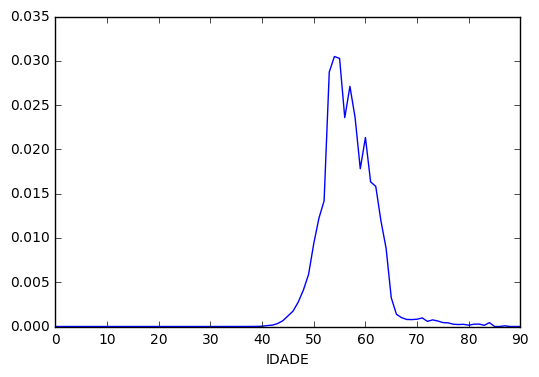

In [212]:
probabilidades[id_aptcn][2014].plot();

In [213]:
import numpy as np

n_execucoes = 15

def calc_qtd_apos(num_segurados, prob_conc, seed):
        
    # Define o seed para geração de números aleatórios
    np.random.seed(seed)
            
    # Gera números aletórios entre 0 e 1 de acordo com a quantidade de segurados
    chance_segurados = np.random.rand(num_segurados)
    
    concessoes = 0

    # Determina quantos irão receber o benefício 
    for chance in chance_segurados:
        # calcula a probabilidade de cada um dos segurados receber o benefício
        # Se o número aleatório for menor ou igual a probabilidade o segurado irá se aposentar
        if chance <= prob_conc: 
            concessoes += 1
            
    #print('{} - {} - {} - {}'.format(num_segurados, prob_conc, chance_segurados[0], concessoes))
    #print(chance_segurados)
    
    return concessoes


# Cria a função que calcula o estoque usando as equações da LDO
def calc_estoq_apos(est, conc, prob, seg, periodo):
    
    # Calcula somente para a Aposentadoria por Tempo de Contribuição
    ids_apos= ['AtcnUrbPisoH']

    # Cria o objeto dados que possui os IDs das tabelas
    dados = LerTabelas()

    # Obtem as aposentadorias para todas as clientelas e sexos
    lista_benef = dados.get_id_beneficios(ids_apos)
        
    for benef in lista_benef:
        # Verifica se o beneficio existe no Estoque
        if benef in est:
        
            sexo = benef[-1]                # Obtém o Sexo
            id_prob_morte = 'Mort'+ sexo    # ex: MortH
            id_fam = 'fam'+benef            # fator de ajuste de mortalidade            
            id_segurado = dados.get_id_segurados(benef)  # ex: CsmUrbH
            
            for ano in periodo:                
                # Adiciona uma nova coluna (ano) no DataFrame com valores zero
                est[benef][ano] = 0
                
                # 1 a 90 anos - Equação 11 da LDO de 2018
                for idade in range(1,91): 
                    est_ano_anterior = est[benef][ano-1][idade-1]
                    prob_sobreviver = 1 - prob[id_prob_morte][ano][idade] * prob[id_fam][ano][idade]
                    entradas = seg[id_segurado][ano][idade] * prob[benef][ano][idade]
                    
                    # Eq. 11
                    est[benef].loc[idade, ano] = est_ano_anterior * prob_sobreviver + entradas     # Eq. 11
                    # Salva a quantidade de concessões para uso posterior
                    conc[benef].loc[idade,ano] = entradas
                
                # Calculo para a idade zero
                est[benef].loc[0, ano] = seg[id_segurado][ano][0] * prob[benef][ano][0]
                # Salva a quantidade de concessões para uso posterior
                conc[benef].loc[0, ano] = est[benef].loc[0, ano]
                
                # Ajuste para a idade de 90+ anos (modelo UFPA) - REVISAR
                est[benef].loc[90, ano] = est[benef].loc[90, ano] + est[benef].loc[90, ano - 1]
                

    return est



# Cria a função que calcula o estoque usando as equações da LDO
def calc_estoq_apos_estocastico(est_2, conc_2, prob, seg, periodo):
    
    # Calcula somente para a Aposentadoria por Tempo de Contribuição
    ids_apos= ['AtcnUrbPisoH']

    # Cria o objeto dados que possui os IDs das tabelas
    dados = LerTabelas()

    # Obtem as aposentadorias para todas as clientelas e sexos
    lista_benef = dados.get_id_beneficios(ids_apos)
        
    for benef in lista_benef:
        # Verifica se o beneficio existe no Estoque
        if benef in est_2:
        
            sexo = benef[-1]                # Obtém o Sexo
            id_prob_morte = 'Mort'+ sexo    # ex: MortH
            id_fam = 'fam'+benef            # fator de ajuste de mortalidade            
            id_segurado = dados.get_id_segurados(benef)  # ex: CsmUrbH
            
            est_seed = dict()
            conc_seed = dict()
            
            seeds = range(0,n_execucoes)
            
            # Para cada um dos seeds
            for seed in seeds:
            
                estoq = copy.deepcopy(est_2)
                conces = copy.deepcopy(conc_2)
                                
                for ano in periodo:                
                    # Adiciona uma nova coluna (ano) no DataFrame com valores zero
                    estoq[benef][ano] = 0

                    # 1 a 90 anos - Equação 11 da LDO de 2018
                    for idade in range(1,91): 
                        est_ano_anterior = estoq[benef][ano-1][idade-1]
                        prob_sobreviver = 1 - prob[id_prob_morte][ano][idade] * prob[id_fam][ano][idade]

                        # MUDEI AQUI
                        qtd_segurados = seg[id_segurado].loc[idade, ano]
                        prob_conc = prob[benef].loc[idade, ano]

                        #print('{} - {}'.format(ano, idade))

                        if qtd_segurados < 1 or prob_conc == 0.0:
                            entradas = 0
                        else:                        
                            entradas = calc_qtd_apos(qtd_segurados, prob_conc, seed)                        
                            #print('{} - {} - {} - D = {} - E = {}'.format(ano, idade, qtd_segurados, entradas))

                        # Eq. 11
                        estoq[benef].loc[idade, ano] = est_ano_anterior * prob_sobreviver + entradas     # Eq. 11
                        # Salva a quantidade de concessões para uso posterior
                        conces[benef].loc[idade,ano] = entradas

                    # Calculo para a idade zero
                    estoq[benef].loc[0, ano] = seg[id_segurado][ano][0] * prob[benef][ano][0]
                    # Salva a quantidade de concessões para uso posterior
                    conces[benef].loc[0, ano] = estoq[benef].loc[0, ano]

                    # Ajuste para a idade de 90+ anos (modelo UFPA) - REVISAR
                    estoq[benef].loc[90, ano] = estoq[benef].loc[90, ano] + estoq[benef].loc[90, ano - 1]
                
                est_seed[seed] = estoq
                conc_seed[seed] = conces
                
        return est_seed, conc_seed


# Cria uma cópia dos dados de estoque
import copy
estoques_2 = copy.deepcopy(estoques)
concessoes_2 = copy.deepcopy(concessoes)

# Executa a função
est_deterministico = calc_estoq_apos(estoques, concessoes, probabilidades, segurados, periodo)
est_estocastico, conc_estocastico = calc_estoq_apos_estocastico(estoques_2, concessoes_2, probabilidades, segurados, periodo)

C:\Users\Patrick\Anaconda3\lib\site-packages\ipykernel\__main__.py:11: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


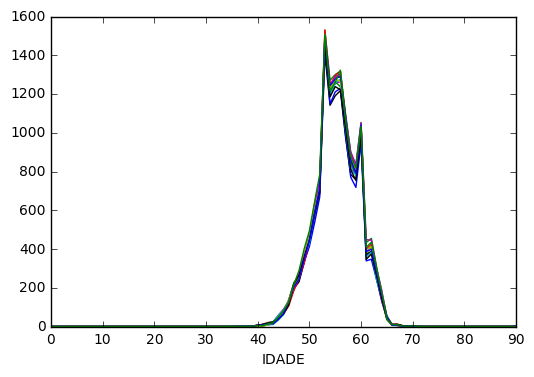

In [214]:
concessoes[id_aptcn][2050].plot();
for seed in conc_estocastico.keys():
    conc_estocastico[seed][id_aptcn][2050].plot();

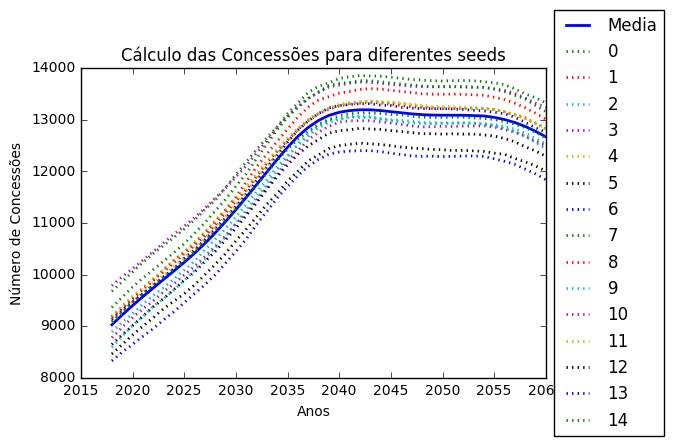

In [215]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(concessoes[id_aptcn].sum().loc[2018:], '-', linewidth=2, label='Media')

for seed in conc_estocastico.keys():
    ax.plot(conc_estocastico[seed][id_aptcn].sum().loc[2018:], ':', linewidth=2, label=seed)    
ax.set_ylabel('Número de Concessões')
ax.set_xlabel('Anos')
ax.set_title('Cálculo das Concessões para diferentes seeds')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [219]:
import numpy as np
import scipy as sp
import scipy.stats
import pandas as pd


def mean_confidence_interval(data, confidence=0.95):
    a = 1.0*np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * sp.stats.t._ppf((1+confidence)/2., n-1)
    return m, m-h, m+h

# Calculando intervalo de confiança das concessoes
resultado = pd.DataFrame(index=periodo, columns=['media', 'LimSup', 'LimInf'])

for ano in periodo:
    temp = []  # lista para salvar os valores de concessões
    for seed in conc_estocastico.keys():
        # Sala o total de concessoes na lista
        temp.append(conc_estocastico[seed][id_aptcn].sum().loc[ano])
        
    #print('{} - {}'.format(ano, temp))
    resultado['media'][ano], resultado['LimSup'][ano], resultado['LimInf'][ano] = mean_confidence_interval(temp)
    


In [251]:
#Testes

from math import sqrt

print(temp)

print('LimInf - Média - LimSup')

##### Metodo 01
med, hi, lw= mean_confidence_interval(temp)
print('{} - {} - {}'.format(hi, med, lw))

##### Método 02
t2 = 1.0*np.array(temp)
med2 = t2.mean()
std2 = t2.std(ddof=1)
d = 1.96 * (std2/sqrt(len(t2)))

print('{} - {} - {}'.format(med2-d, med2, med2+d))

##### Método 03
from scipy import stats

mean, sigma = np.mean(t2), np.std(t2)
conf_int = stats.norm.interval(0.95, loc=mean, scale=sigma)
print('{} - {} - {}'.format(conf_int[0], mean, conf_int[1]))


[13322.0, 13006.0, 12527.0, 12490.0, 12828.0, 12000.0, 11833.0, 12640.0, 12820.0, 12430.0, 13232.0, 12819.0, 12286.0, 12754.0, 13155.0]
LimInf - Média - LimSup
12438.702825251163 - 12676.133333333333 - 12913.563841415504
12459.158937481861 - 12676.133333333333 - 12893.107729184805
11864.304400176135 - 12676.133333333333 - 13487.962266490531


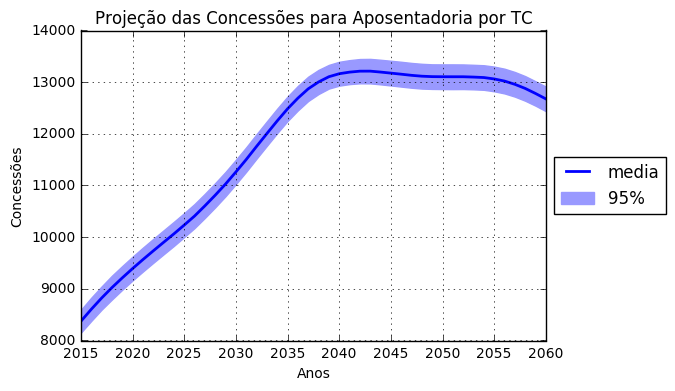

In [218]:
fig, ax = plt.subplots()
ax.plot(resultado['media'], '-', linewidth=2)
#ax.plot(resultado['LimSup'], '-', linewidth=2, color=(0, 0, 0))
#ax.plot(resultado['LimInf'], '-', linewidth=2, color=(0, 0, 0))
c = 1
ax.fill_between(periodo, resultado['LimSup'].tolist(), resultado['LimInf'].tolist(),
                     color=(0.8-0.20*c, 0.8-0.20*c, 1.0),     
                     facecolor=(0.8-0.20*c, 0.8-0.20*c, 1.0),
                     label='95%')     

ax.set_ylabel('Concessões')
ax.set_xlabel('Anos')
ax.set_title('Projeção das Concessões para Aposentadoria por TC')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.show()